# Read Export Files

In [1]:
# Imports
import numpy as np
import pandas as pd
from sympy.utilities.lambdify import lambdify
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib.ticker import LogLocator

In [2]:
# Official package: https://pypi.org/project/ltspice/
# Derived LTspice reader
def read_ltspice(file_name,ftype='trans',units='db'):
    cols = []
    arrs = []
    with open(file_name, 'r',encoding='utf-8') as data:
        for i,line in enumerate(data):
            if i==0:
                cols = line.split()
                arrs = [[] for _ in cols]
                continue
            parts = line.split()
            for j,part in enumerate(parts):
                arrs[j].append(part)
    df = pd.DataFrame(arrs)
    df = df.T
    df.astype('float64',errors='ignore')
    df.columns = cols
    if ftype=='trans':
        return df
    elif ftype=='ac':
        if units=='db':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Mag_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].apply(lambda x: x[1:-2])
                    df[f'Mag_{col}'] = df[f'Mag_{col}'].astype('float64')
                    df[f'Phase_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].apply(lambda x: x[0:-2])
                    df[f'Phase_{col}'] = df[f'Phase_{col}'].astype('float64')
        if units=='cartesian':
            for col in cols:
                if df[col].str.contains(',').all():
                    df[f'Re_{col}'] = df[col].apply(lambda x: x.split(',')[0])
                    df[f'Re_{col}'] = df[f'Re_{col}'].astype('float64')
                    df[f'Im_{col}'] = df[col].apply(lambda x: x.split(',')[1])
                    df[f'Im_{col}'] = df[f'Im_{col}'].astype('float64')
        df['Freq.'] = df['Freq.'].astype('float64')
        return df
    else:
        print('invalid ftype')

In [3]:
filepath = 'data/top_level_OP1177.txt'
df = read_ltspice(filepath,'ac')
df.head(n=2).style.format(precision=3)

,Freq.,V(vout3)/(V(vp)-V(vm)),Mag_V(vout3)/(V(vp)-V(vm)),Phase_V(vout3)/(V(vp)-V(vm))
0,0.010,"(-4.11838015619366e+001dB,-5.59733635143613e-001°)",-41.184,-0.560
1,0.010,"(-4.07837855425980e+001dB,-5.72769990801834e-001°)",-40.784,-0.573


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


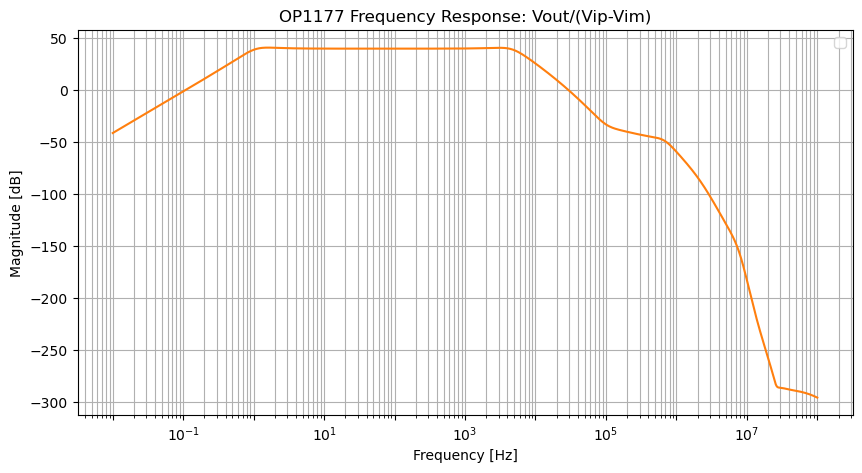

In [4]:
fig, ax = plt.subplots(1,figsize=(10,5))
freq = df['Freq.']
mag = df['Mag_V(vout3)/(V(vp)-V(vm))']

ax.semilogx(freq, mag, color='tab:orange')
ax.grid(True,which='both')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Magnitude [dB]')
ax.set_title('OP1177 Frequency Response: Vout/(Vip-Vim)')

# overrides matplotlib -> won't plot bode lines if dimension size isn't big enough
# manipulate x-axis ticks and labels
ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False) #(3)

ax.legend()
plt.show();